In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import IntegerComparator, DraperQFTAdder
from qiskit_aer import AerSimulator

n = 4
p = 13
x_val = 2
y_val = 1
x = QuantumRegister(n, 'x')          # |x> 레지스터 (n 큐비트)
y = QuantumRegister(n, 'y')          # |y> 레지스터 (n 큐비트, 최종 결과 저장)
z = QuantumRegister(n, 'z')
carry = QuantumRegister(1, 'carry')  # 캐리 비트 (1 큐비트)
zero = QuantumRegister(1, 'zero')    # squ_modp에 사용됨됨
aux = QuantumRegister(n, 'aux')      # 보조 큐비트 (IntegerComparator 사용)
c = ClassicalRegister(n, 'c')        # 결과 측정용 레지스터

In [7]:
def add_modp(n, p, qx, qy, qcarry, qaux):
    # 양자 레지스터 정의
    
    # 양자 회로 생성
    qc = QuantumCircuit(qx, qy, qcarry, qaux)
    
    # (1) 덧셈: |y> <- |x + y>
    adderWithCarry = DraperQFTAdder(n, kind='half').to_gate()
    qc.append(adderWithCarry, qx[:] + qy[:] + qcarry[:])  # x와 y를 더한 값을 y에 저장

    p_positive = format(p, f'0{n}b')
    
    for i in range(n): 
        if p_positive[n - 1 - i] == '1':
            qc.x(qaux[i])
    
    # (2) 뺄셈
    qc.append(adderWithCarry.inverse(), qaux[:] + qy[:] + qcarry[:])
    
    # (3) control 덧셈
    adderNoCarry = DraperQFTAdder(n, kind='fixed').to_gate()
    qc.append(adderNoCarry.control(1), qcarry[:] + qaux[:] + qy[:])

    # (4) 비교
    comparator = IntegerComparator(n, p, geq=True).to_gate()
    qc.append(comparator, qy[:] + qcarry[:] + qaux[:n-1])
    
    qc.x(qcarry)
    
    # (5) 초기화
    for i in range(n): 
        if p_positive[n - 1 - i] == '1':
            qc.x(qaux[i])

    

    return qc.to_gate()

# 예제 실행

circuit = QuantumCircuit(x, y, z, carry, aux, c)

L = 10
x_val=10
y_val=11

for x_val in range(L):
    for y_val in range(L):
        x_bin = format(x_val, f'0{n}b')  # x_val을 n비트 이진수로 변환
        y_bin = format(y_val, f'0{n}b')
        for i in range(n):
            if x_bin[n - 1 - i] == '1':
                circuit.x(x[i])  # |x> 초기화
        for i in range(n):
            if y_bin[n - 1 - i] == '1':
                circuit.x(y[i])  # |x> 초기화
 
        circuit.append(add_modp(n, p, x, y, carry, aux), x[:] + y[:] + [carry[0]] + aux[:])

        circuit.barrier()

        # 결과 측정 (x 레지스터 측정)
        #circuit.measure(x, c)
        circuit.measure(y, c)
        #circuit.measure(aux, c)
        #print(qc)

        # 시뮬레이션
        backend = AerSimulator(method='statevector')
        qc_transpiled = transpile(circuit, backend=backend, optimization_level=3)
        job = backend.run(qc_transpiled, shots=1000)
        result = job.result()
        counts = result.get_counts()

        # 결과 출력
        print(f"입력값: x = {x_val}, y={y_val}, p = {p}")
        print("측정 결과:", counts)

        # 예상 결과와 비교
        expected = (x_val + y_val) % p
        expected_bin = format(expected, f'0{n}b')
        print(f"예상 결과 (고전적 계산): {expected} ({expected_bin})")

        for i in range(n):
            if x_bin[n - 1 - i] == '1':
                circuit.x(x[i])  # |x> 초기화
        for i in range(n):
            if y_bin[n - 1 - i] == '1':
                circuit.x(y[i])  # |x> 초기화
 

circuit.decompose().draw('mpl')
#print(circuit)


입력값: x = 0, y=0, p = 5
측정 결과: {'0000': 1000}
예상 결과 (고전적 계산): 0 (0000)
입력값: x = 0, y=1, p = 5
측정 결과: {'1100': 1000}
예상 결과 (고전적 계산): 1 (0001)
입력값: x = 0, y=2, p = 5
측정 결과: {'1010': 1000}
예상 결과 (고전적 계산): 2 (0010)
입력값: x = 0, y=3, p = 5
측정 결과: {'0110': 1000}
예상 결과 (고전적 계산): 3 (0011)
입력값: x = 0, y=4, p = 5
측정 결과: {'1100': 1000}
예상 결과 (고전적 계산): 4 (0100)
입력값: x = 0, y=5, p = 5
측정 결과: {'1000': 1000}
예상 결과 (고전적 계산): 0 (0000)
입력값: x = 0, y=6, p = 5
측정 결과: {'0110': 1000}
예상 결과 (고전적 계산): 1 (0001)
입력값: x = 0, y=7, p = 5
측정 결과: {'0111': 1000}
예상 결과 (고전적 계산): 2 (0010)
입력값: x = 0, y=8, p = 5
측정 결과: {'0011': 1000}
예상 결과 (고전적 계산): 3 (0011)
입력값: x = 0, y=9, p = 5
측정 결과: {'0010': 1000}
예상 결과 (고전적 계산): 4 (0100)
입력값: x = 1, y=0, p = 5
측정 결과: {'1100': 1000}
예상 결과 (고전적 계산): 1 (0001)
입력값: x = 1, y=1, p = 5
측정 결과: {'1110': 1000}
예상 결과 (고전적 계산): 2 (0010)
입력값: x = 1, y=2, p = 5
측정 결과: {'1110': 1000}
예상 결과 (고전적 계산): 3 (0011)
입력값: x = 1, y=3, p = 5
측정 결과: {'0000': 1000}
예상 결과 (고전적 계산): 4 (0100)
입력값: x = 1, y=4, p =

입력값: x = 10, p = 13
측정 결과: {'0111': 1000}
예상 결과 (고전적 계산): 7 (0111)


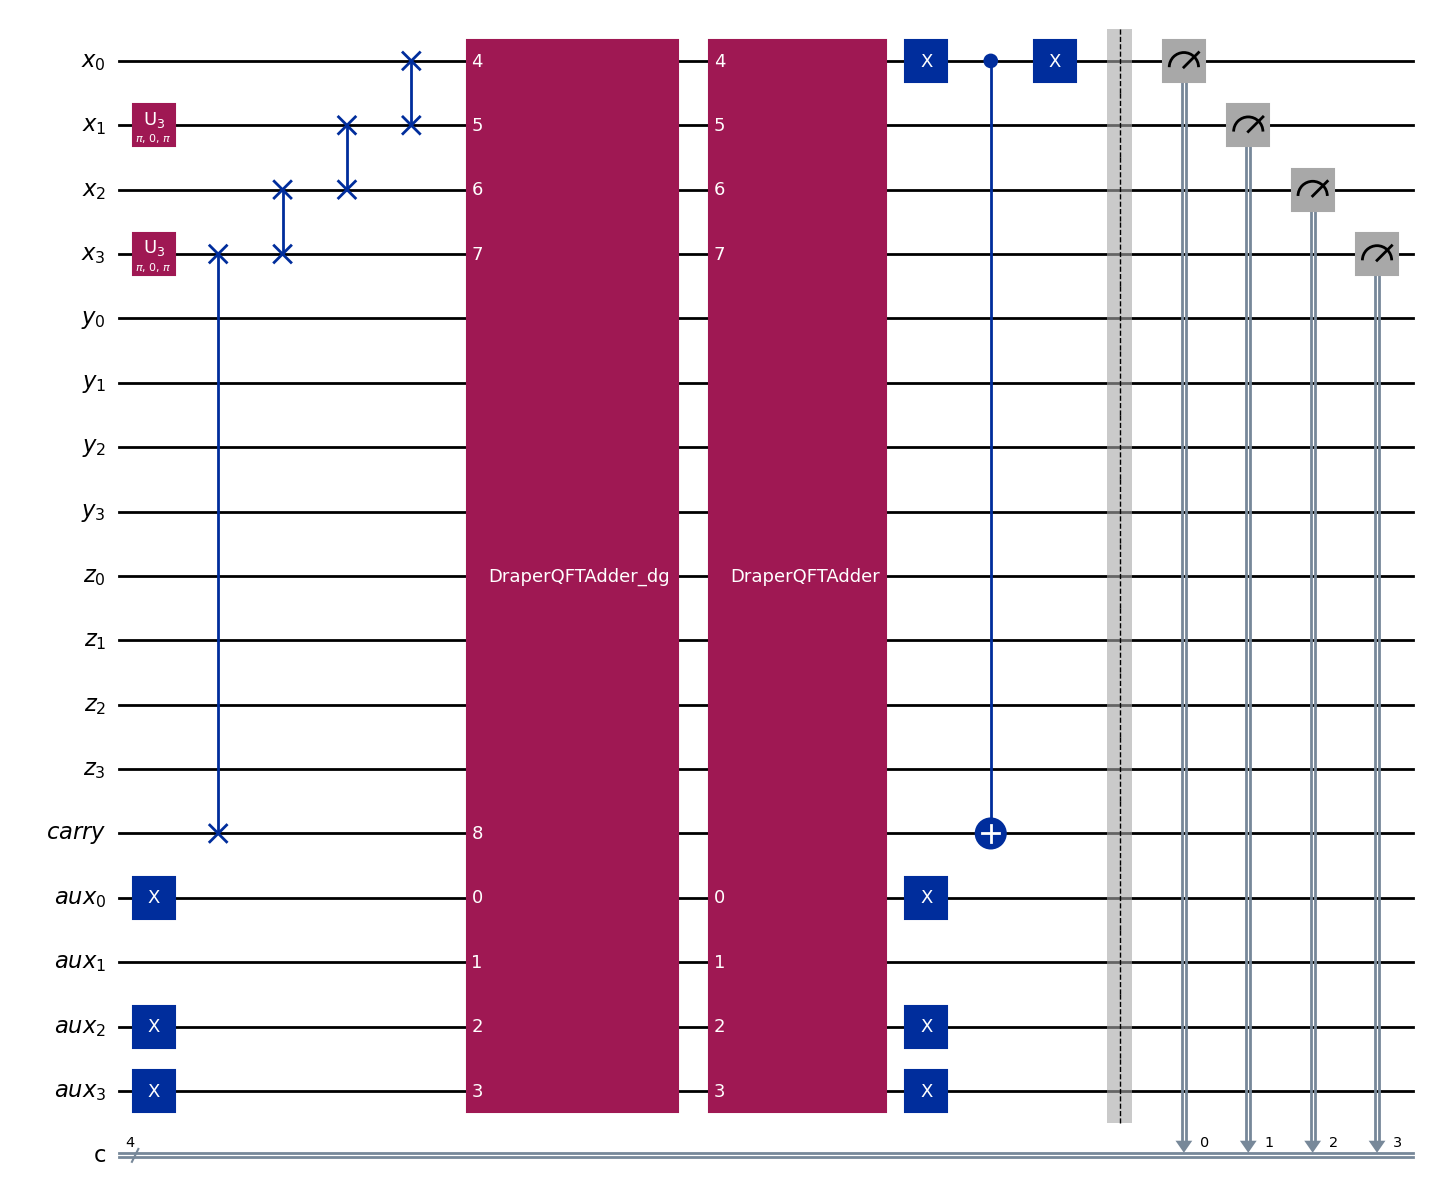

In [3]:
def dbl_modp(n, p, qx, qcarry, qaux):
    
    # 양자 회로 생성
    qc = QuantumCircuit(qx, qcarry, qaux)

    # 1: shift
    qc.swap(qx[n-1], qcarry)
    for i in range(n-1):
        qc.swap(qx[n-i-2], qx[n-i-1])
    
    p_positive = format(p, f'0{n}b')
    
    for i in range(n): 
        if p_positive[n - 1 - i] == '1':
            qc.x(qaux[i])
    

    # (2) 뺄셈
    adderWithCarry = DraperQFTAdder(n, kind='half').to_gate()
    qc.append(adderWithCarry.inverse(), qaux[:] + qx[:] + qcarry[:])    

    # (3) control 덧셈
    adderNoCarry = DraperQFTAdder(n, kind='fixed').to_gate()
    qc.append(adderNoCarry.control(1), qcarry[:] + qaux[:] + qx[:])

    qc.x(qx[0])
    qc.cx(qx[0], qcarry)
    qc.x(qx[0])

    # (5) 초기화
    for i in range(n): 
        if p_positive[n - 1 - i] == '1':
            qc.x(qaux[i])
    

    
    return qc.to_gate()

    

circuit = QuantumCircuit(x, y, z, carry, aux, c)

x_bin = format(x_val, f'0{n}b')  # x_val을 n비트 이진수로 변환
for i in range(n):
    if x_bin[n - 1 - i] == '1':
        circuit.x(x[i])  # |x> 초기화


circuit.append(dbl_modp(n, p, x, carry, aux), x[:] + carry[:] + aux[:])

circuit.barrier()

# 결과 측정 (x 레지스터 측정)
circuit.measure(x, c)
#circuit.measure(carry, c)
#circuit.measure(aux, c)
#print(qc)

# 시뮬레이션
backend = AerSimulator(method='statevector')
qc_transpiled = transpile(circuit, backend=backend, optimization_level=3)
job = backend.run(qc_transpiled, shots=1000)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(f"입력값: x = {x_val}, p = {p}")
print("측정 결과:", counts)

# 예상 결과와 비교
expected = (x_val * 2) % p
expected_bin = format(expected, f'0{n}b')
print(f"예상 결과 (고전적 계산): {expected} ({expected_bin})")

circuit.decompose().draw('mpl')
#print(circuit)

입력값: x = 3, y = 3 p = 5
측정 결과: {'0101': 1000}
예상 결과 (고전적 계산): 4 (0100)


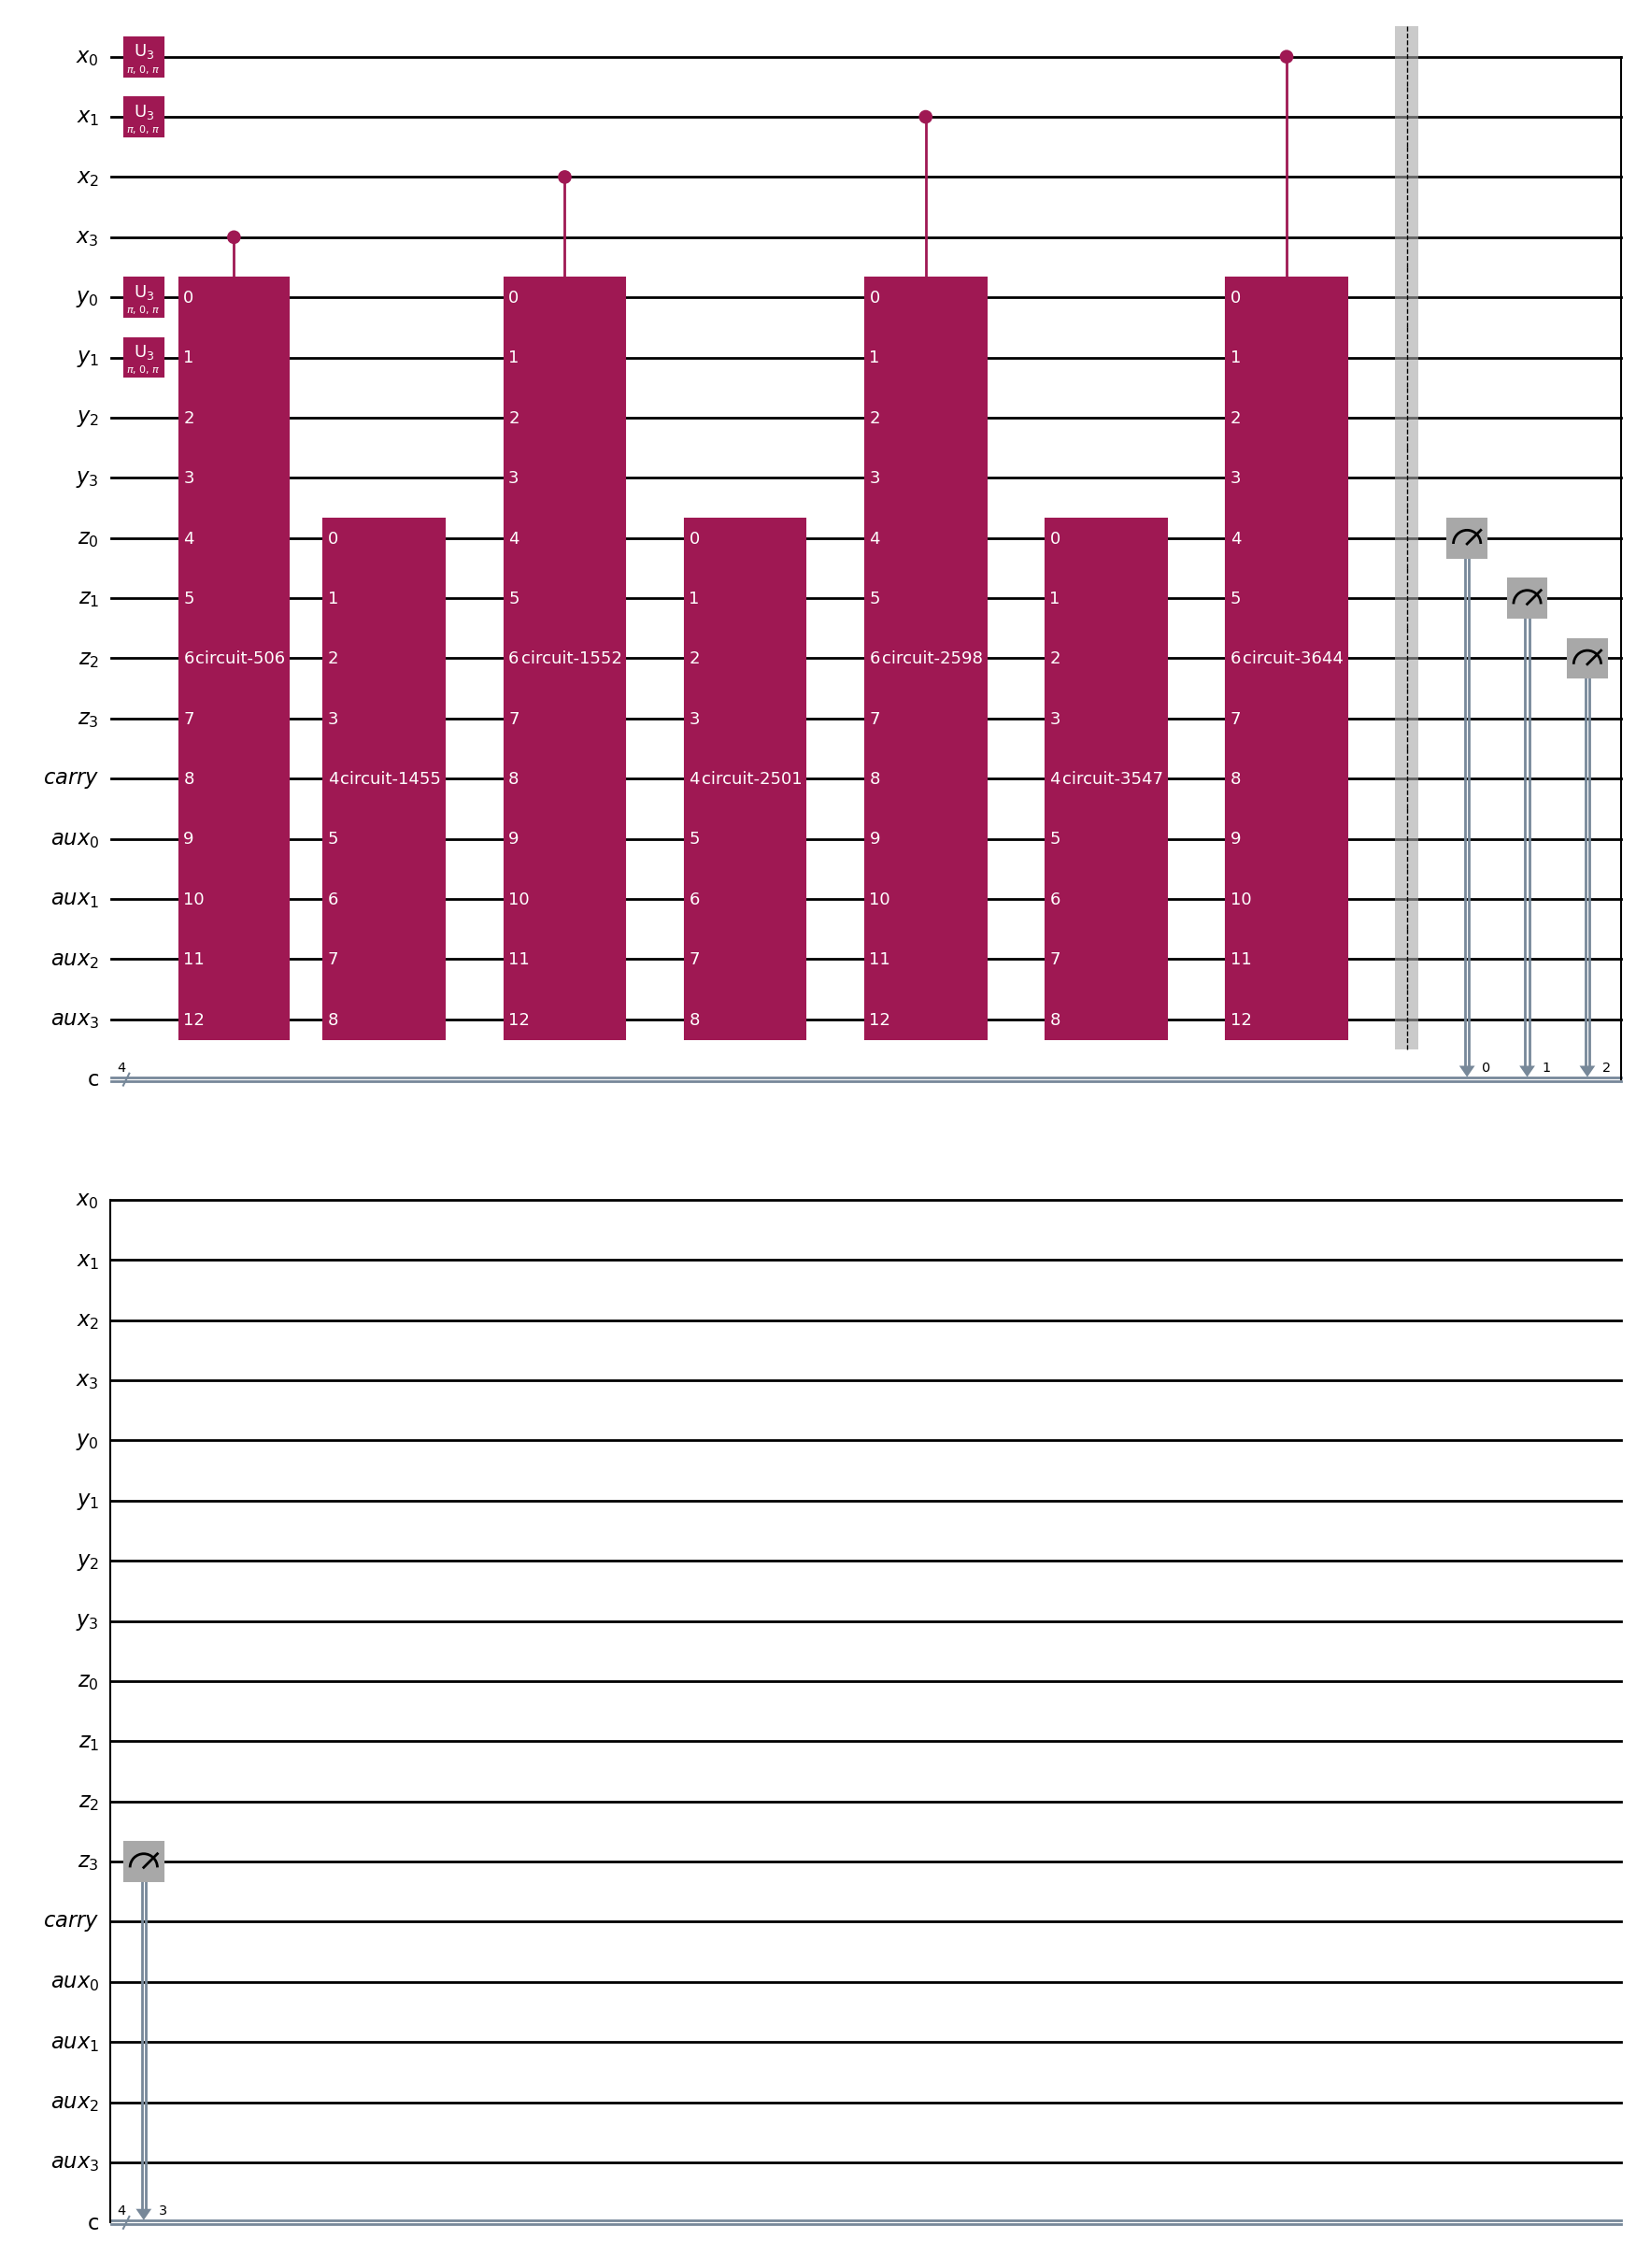

In [4]:
def mul_modp(n, p, qx, qy, qz, qcarry, qaux):
    
    # 양자 회로 생성
    qc = QuantumCircuit(qx, qy, qz, qcarry, qaux)

    for i in range(n):
        qc.append(add_modp(n, p, qy, qz, qcarry, qaux).control(1), [qx[n-i-1]] + qy[:] + qz[:] + qcarry[:] + qaux[:])
        if i != n-1:
            qc.append(dbl_modp(n, p, qz, qcarry, qaux), qz[:] + qcarry[:] + qaux[:])

    return qc.to_gate()



circuit = QuantumCircuit(x, y, z, carry, aux, c)

x_val = 3
y_val = 3
p = 5
x_bin = format(x_val, f'0{n}b')  # x_val을 n비트 이진수로 변환
y_bin = format(y_val, f'0{n}b')  # y_val을 n비트 이진수로 변환
    
for i in range(n):
    if x_bin[n - 1 - i] == '1':
        circuit.x(x[i])  # |x> 초기화
    if y_bin[n - 1 - i] == '1':
        circuit.x(y[i])  # |y> 초기화



circuit.append(mul_modp(n, p, x, y, z, carry, aux), x[:] + y[:] + z[:] + carry[:] + aux[:])
#circuit.decompose().draw('mpl')

circuit.barrier()

# 결과 측정 (x 레지스터 측정)
circuit.measure(z, c)
#qc.measure(carry, c)
#circuit.measure(aux, c)
#print(qc)

# 시뮬레이션
backend = AerSimulator(method='statevector')
qc_transpiled = transpile(circuit, backend=backend, optimization_level=3)
job = backend.run(qc_transpiled, shots=1000)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(f"입력값: x = {x_val}, y = {y_val} p = {p}")
print("측정 결과:", counts)

# 예상 결과와 비교
expected = (x_val * y_val) % p
expected_bin = format(expected, f'0{n}b')
print(f"예상 결과 (고전적 계산): {expected} ({expected_bin})")


circuit.decompose().draw('mpl')


입력값: x = 3, p = 5
측정 결과: {'0101': 1000}
예상 결과 (고전적 계산): 4 (0100)


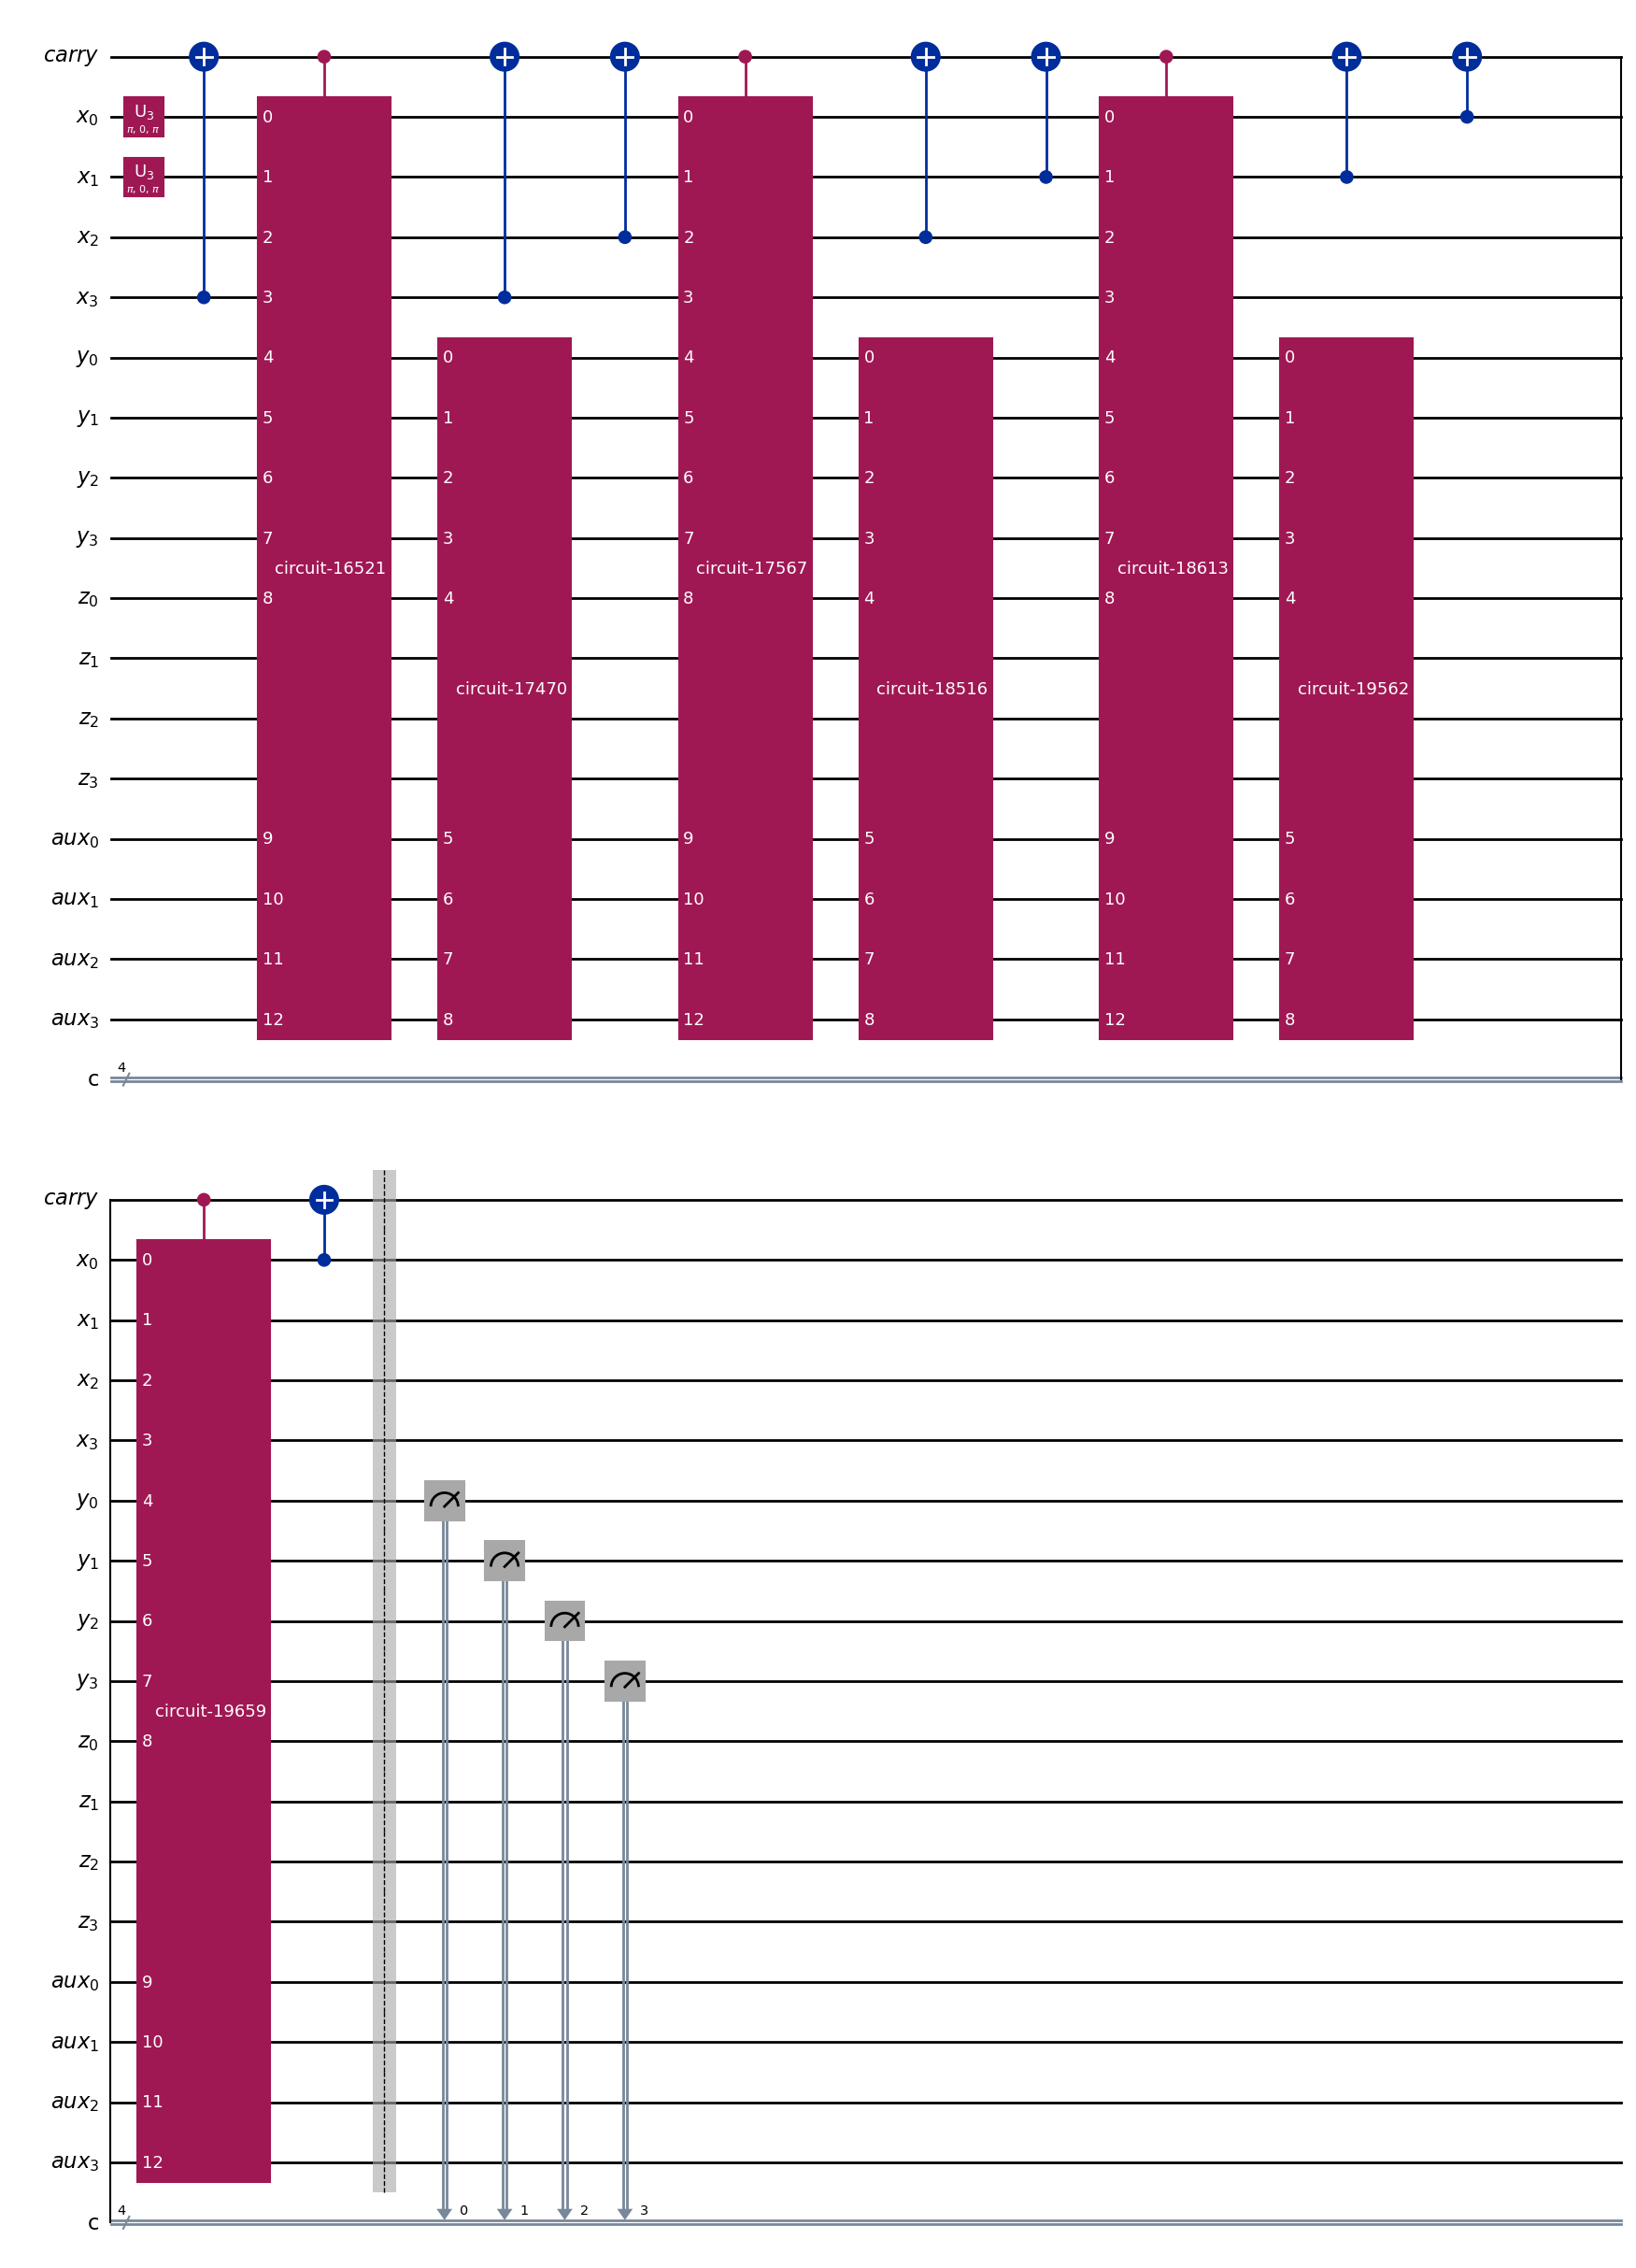

In [11]:
def squ_modp(n, p, qx, qy, qz, qcarry, qaux):
    
    # 양자 회로 생성
    qc = QuantumCircuit(qx, qy, qz, qcarry, qaux)

    
    for i in range(n):        
        qc.cx(qx[n-i-1], qcarry[0])
        qc.append(add_modp(n, p, qx, qy, qcarry, qaux).control(1), qcarry[:] + qx[:] + qy[:] + qz[:1] + qaux[:])
        qc.cx(qx[n-i-1], qcarry[0])
        if i != n-1:
            qc.append(dbl_modp(n, p, qy, qcarry, qaux), qy[:] + qz[:1] + qaux[:])

    return qc.to_gate()



circuit = QuantumCircuit(carry, x, y, z, aux, c)


x_bin = format(x_val, f'0{n}b')  # x_val을 n비트 이진수로 변환
y_bin = format(y_val, f'0{n}b')  # y_val을 n비트 이진수로 변환
    
for i in range(n):
    if x_bin[n - 1 - i] == '1':
        circuit.x(x[i])  # |x> 초기화
    #if y_bin[n - 1 - i] == '1':
    #    circuit.x(y[i])  # |y> 초기화



circuit.append(squ_modp(n, p, x, y, z, carry, aux), x[:] + y[:] + z[:] + carry[:] + aux[:])
#circuit.decompose().draw('mpl')

circuit.barrier()

# 결과 측정 
#circuit.measure(y, c)
circuit.measure(y, c)
#circuit.measure(carry, c)
#circuit.measure(aux, c)
#print(qc)

# 시뮬레이션
backend = AerSimulator(method='statevector')
qc_transpiled = transpile(circuit, backend=backend, optimization_level=3)
job = backend.run(qc_transpiled, shots=1000)
result = job.result()
counts = result.get_counts()

# 결과 출력
print(f"입력값: x = {x_val}, p = {p}")
print("측정 결과:", counts)

# 예상 결과와 비교
expected = (x_val**2) % p
expected_bin = format(expected, f'0{n}b')
print(f"예상 결과 (고전적 계산): {expected} ({expected_bin})")


circuit.decompose().draw('mpl')


In [ ]:
def inv_modp(n, p, qx, qy, qz, qcarry, qaux):
    
    # 양자 회로 생성
    qc = QuantumCircuit(qx, qy, qz, qcarry, qaux)

    
    for i in range(n):        
        qc.cx(qx[n-i-1], qcarry[0])
        qc.append(add_modp(n, p, qx, qy, qcarry, qaux).control(1), qcarry[:] + qx[:] + qy[:] + qz[:1] + qaux[:])
        qc.cx(qx[n-i-1], qcarry[0])
        if i != n-1:
            qc.append(dbl_modp(n, p, qy, qcarry, qaux), qy[:] + qz[:1] + qaux[:])

    return qc.to_gate()



circuit = QuantumCircuit(carry, x, y, z, aux, c)


x_bin = format(x_val, f'0{n}b')  # x_val을 n비트 이진수로 변환
y_bin = format(y_val, f'0{n}b')  # y_val을 n비트 이진수로 변환
    
for i in range(n):
    if x_bin[n - 1 - i] == '1':
        circuit.x(x[i])  # |x> 초기화
    #if y_bin[n - 1 - i] == '1':
    #    circuit.x(y[i])  # |y> 초기화


